# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from IPython.display import FileLink
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn import linear_model
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import (
    cross_val_score,
    cross_val_predict, 
    ShuffleSplit, 
    GridSearchCV,
    KFold,
    train_test_split,
)
from sklearn.neighbors import kneighbors_graph
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GraphSAGE, SAGEConv
from torch_geometric.data import Data, DataLoader
import optuna

# Download the Data

In [2]:
supercond_df = pd.read_csv('/home/ckasemtantikul/cleaned_supercond_df.csv')
final_design_matrix_supercond = pd.read_csv('/home/ckasemtantikul/final_design_matrix_supercond.csv')
df = pd.merge(supercond_df, final_design_matrix_supercond, left_index=True, right_index=True, how='left')
df = df.dropna()

In [3]:
X = df.drop(['chemical_formula','Tc','composition','elements','Category','num_elements','stoichiometry'], axis=1)
y = df[['Tc']]
display(X)
display(y)

,Average AtomicRadius,Average AtomicVolume,Average AtomicWeight,Average BoilingT,Average CovalentRadius,Average Density,Average ElectronAffinity,Average Electronegativity,Average FirstIonizationEnergy,Average HeatCapacityMass,...,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char
0,1.097143,10637.113673,57.873967,1542.185714,115.885714,2974.616571,110.470357,2.546929,10.471085,0.635479,...,95.178571,95.061224,12.0,1.857143,2.285714,1.692857,0.000000,False,0.803211,0.165284
1,1.093929,10636.906970,56.808817,1531.728571,115.457143,2955.759429,110.279214,2.548214,10.481439,0.637664,...,95.092857,94.963265,12.0,1.857143,2.285714,1.692857,0.000000,False,0.787757,0.164994
2,1.047143,10635.250819,67.135606,1514.857143,110.800000,3905.930857,110.741429,2.589143,10.429637,0.625000,...,95.428571,95.346939,12.0,1.857143,2.285714,1.685714,3.600000,False,0.803211,0.155938
3,1.094643,10637.075533,56.330499,1519.428571,115.571429,2899.123714,109.180857,2.544571,10.475865,0.639450,...,95.092857,94.963265,12.0,1.864286,2.285714,1.628571,0.000000,False,0.787757,0.165653
4,1.094286,10637.036937,56.424486,1517.542857,115.401429,2926.630857,109.875429,2.546757,10.480881,0.638606,...,95.320000,95.222857,12.0,1.858571,2.285714,1.675714,0.000000,False,0.787757,0.165292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8833,1.196667,26.523951,80.111022,1944.373667,130.100000,5445.850000,74.800000,1.962833,9.149645,0.550150,...,78.466667,77.022222,2.0,2.000000,2.183333,0.600000,4.666667,False,0.348856,0.053305
8834,1.203333,26.765795,79.993582,1904.340333,130.500000,5330.216667,76.466667,1.961833,9.103004,0.550483,...,78.466667,77.022222,2.0,2.000000,2.183333,0.566667,4.666667,False,0.348856,0.053562
8835,1.210000,27.007639,79.876142,1864.307000,130.900000,5214.583333,78.133333,1.960833,9.056364,0.550817,...,78.466667,77.022222,2.0,2.000000,2.183333,0.533333,4.666667,False,0.348856,0.053819
8836,1.216667,27.249483,79.758702,1824.273667,131.300000,5098.950000,79.800000,1.959833,9.009724,0.551150,...,78.466667,77.022222,2.0,2.000000,2.183333,0.500000,4.666667,False,0.348856,0.054076


,Tc
0,30.00
1,39.00
2,71.90
3,21.00
4,12.00
...,...
8833,4.09
8834,4.85
8835,4.48
8836,5.87


# Train Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, shuffle=True)

# Apply normalization to X

In [5]:
# Normalize train

scaler = StandardScaler()
scaler.fit(X_train)
means_ = scaler.mean_
stds_ = scaler.scale_
norm_train_X = scaler.transform(X_train)

column_names = X_train.columns
norm_train_X = pd.DataFrame(scaler.transform(X_train), columns=column_names)
norm_train_X.columns = norm_train_X.columns.str.replace(' ', '_').str.replace(r'(?<!^)(?=[A-Z])', '_').str.lower()

scaler = StandardScaler()
scaler.fit(X_test)
means_ = scaler.mean_
stds_ = scaler.scale_
norm_test_X = scaler.transform(X_test)

column_names = X_train.columns
norm_test_X = pd.DataFrame(scaler.transform(X_test), columns=column_names)
norm_test_X.columns = norm_test_X.columns.str.replace(' ', '_').str.replace(r'(?<!^)(?=[A-Z])', '_').str.lower()

# Convert Dataframe to Numpy array

In [6]:
norm_train_X = norm_train_X.to_numpy() if hasattr(norm_train_X, 'to_numpy') else norm_train_X
norm_test_X = norm_test_X.to_numpy() if hasattr(norm_test_X, 'to_numpy') else norm_test_X
y_train = y_train.to_numpy() if hasattr(y_train, 'to_numpy') else y_train
y_test = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else y_test

# Define GNN model and parameters

In [7]:
device = torch.device('cpu')

# Create a KNN graph for your training data
k = 10  # Adjust the number of neighbors
knn_graph_train = kneighbors_graph(norm_train_X, k, mode='connectivity', include_self=True)
edge_index_train = torch.tensor(np.array(knn_graph_train.nonzero()), dtype=torch.long)

knn_graph_test = kneighbors_graph(norm_test_X, k, mode='connectivity', include_self=True)
edge_index_test = torch.tensor(np.array(knn_graph_test.nonzero()), dtype=torch.long)

# Convert your features and labels to tensors
x_train = torch.tensor(norm_train_X, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).view(-1, 1).to(device)
x_test = torch.tensor(norm_test_X, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).view(-1, 1).to(device)

# Create PyTorch Geometric data objects
train_data = Data(x=x_train, edge_index=edge_index_train, y=y_train)
test_data = Data(x=x_test, edge_index=edge_index_test, y=y_test)

# Create data loaders
train_loader = DataLoader([train_data], batch_size=1, shuffle=True)
test_loader = DataLoader([test_data], batch_size=1)

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_layers, dropout_rate):
        super(GNNModel, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(num_features, hidden_channels))
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.lin = torch.nn.Linear(hidden_channels, 1)
        self.dropout_rate = dropout_rate

    def forward(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.lin(x)
        return x

/opt/conda/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# Hyperparameter tuning with optuna

# (Skip this part if already tuned)

In [8]:
def objective(trial):
    hidden_channels = trial.suggest_int('hidden_channels', 32, 256)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    num_layers = trial.suggest_int('num_layers', 2, 5)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # Initialize model, loss function, and optimizer
    model = GNNModel(num_features=norm_train_X.shape[1], hidden_channels=hidden_channels, num_layers=num_layers, dropout_rate=dropout_rate).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = torch.nn.MSELoss()

    # Training loop
    model.train()
    for epoch in range(50):  # Increase epochs for better training
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()

    # Evaluation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            pred = model(batch.x, batch.edge_index)
            batch_loss = mean_squared_error(batch.y.cpu(), pred.cpu())
            val_loss += batch_loss
        val_loss /= len(test_loader)

    return val_loss

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # Increase number of trials

[I 2024-05-30 04:17:59,939] A new study created in memory with name: no-name-ac2a122b-eb04-42e1-97c7-3a467dbb696a
[I 2024-05-30 04:18:11,446] Trial 0 finished with value: 322.15087890625 and parameters: {'hidden_channels': 89, 'learning_rate': 0.0009482559934316206, 'weight_decay': 0.00017171331965491903, 'num_layers': 3, 'dropout_rate': 0.45749029477299963}. Best is trial 0 with value: 322.15087890625.
[I 2024-05-30 04:18:25,646] Trial 1 finished with value: 288.568603515625 and parameters: {'hidden_channels': 105, 'learning_rate': 0.002061451681107582, 'weight_decay': 0.0004433181500587321, 'num_layers': 3, 'dropout_rate': 0.347556677592114}. Best is trial 1 with value: 288.568603515625.
[I 2024-05-30 04:18:53,462] Trial 2 finished with value: 944.7864990234375 and parameters: {'hidden_channels': 206, 'learning_rate': 7.292567009551672e-05, 'weight_decay': 1.945474692174082e-05, 'num_layers': 4, 'dropout_rate': 0.45575344767726256}. Best is trial 1 with value: 288.568603515625.
[I 20

[I 2024-05-30 04:26:09,432] Trial 28 finished with value: 299.2892150878906 and parameters: {'hidden_channels': 217, 'learning_rate': 0.0005830744719066719, 'weight_decay': 5.7951722088436524e-05, 'num_layers': 3, 'dropout_rate': 0.355286190555227}. Best is trial 27 with value: 231.24720764160156.
[I 2024-05-30 04:26:24,335] Trial 29 finished with value: 277.7347717285156 and parameters: {'hidden_channels': 237, 'learning_rate': 0.0008342030781506742, 'weight_decay': 9.910559278162742e-05, 'num_layers': 2, 'dropout_rate': 0.31790203460194916}. Best is trial 27 with value: 231.24720764160156.
[I 2024-05-30 04:26:52,848] Trial 30 finished with value: 267.5850524902344 and parameters: {'hidden_channels': 218, 'learning_rate': 0.005628806569728626, 'weight_decay': 0.00020722157044759574, 'num_layers': 4, 'dropout_rate': 0.3811292737270874}. Best is trial 27 with value: 231.24720764160156.
[I 2024-05-30 04:27:06,131] Trial 31 finished with value: 250.0270538330078 and parameters: {'hidden_c

# Training the final model with best hyperparameters

In [9]:
best_params = study.best_params
print(best_params)

# Initialize the model with the best hyperparameters found
model = GNNModel(num_features=norm_train_X.shape[1], hidden_channels=best_params['hidden_channels'], num_layers=best_params['num_layers'], dropout_rate=best_params['dropout_rate']).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
criterion = torch.nn.MSELoss()

# Training loop with the best hyperparameters and more epochs
model.train()
for epoch in range(100):  # Increased number of epochs
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        
# Save the model
torch.save(model.state_dict(), 'gnn_model.pth')

{'hidden_channels': 239, 'learning_rate': 0.007092419543561266, 'weight_decay': 0.0006617145213958432, 'num_layers': 2, 'dropout_rate': 0.1493314224830723}


In [10]:
# Predictions
model.eval()
with torch.no_grad():
    pred_train_y = model(x_train, edge_index_train).cpu().numpy()
    pred_test_y = model(x_test, edge_index_test).cpu().numpy()

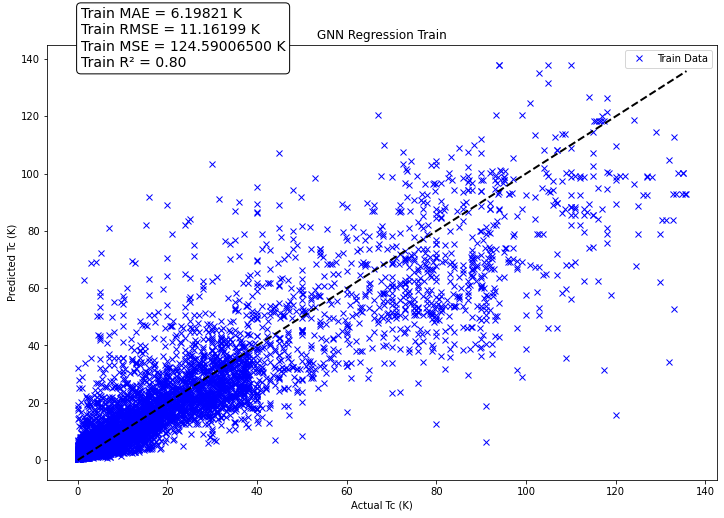

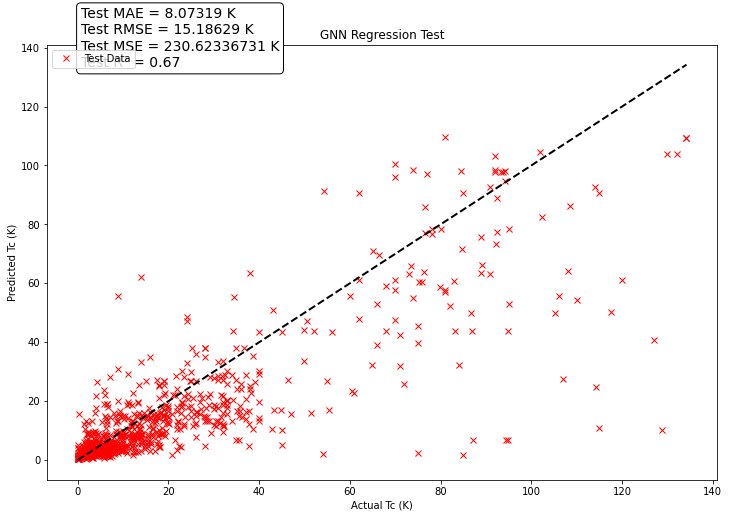

In [11]:
# Calculate metrics for train data
mae_train = mean_absolute_error(y_train.cpu().numpy(), pred_train_y)
rmse_train = mean_squared_error(y_train.cpu().numpy(), pred_train_y, squared=False)
mse_train = mean_squared_error(y_train.cpu().numpy(), pred_train_y, squared=True)
r2_train = r2_score(y_train.cpu().numpy(), pred_train_y)

# Calculate metrics for test data
mae_test = mean_absolute_error(y_test.cpu().numpy(), pred_test_y)
rmse_test = mean_squared_error(y_test.cpu().numpy(), pred_test_y, squared=False)
mse_test = mean_squared_error(y_test.cpu().numpy(), pred_test_y, squared=True)
r2_test = r2_score(y_test.cpu().numpy(), pred_test_y)

# Plot results for train data
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(y_train.cpu().numpy(), pred_train_y, "bx", label="Train Data")
plt.xlabel("Actual Tc (K)")
plt.ylabel("Predicted Tc (K)")
plt.title("GNN Regression Train")
plt.plot([min(y_train.cpu().numpy()), max(y_train.cpu().numpy())], 
         [min(y_train.cpu().numpy()), max(y_train.cpu().numpy())], "k--", linewidth=2)
plt.annotate(f"Train MAE = {mae_train:.5f} K\nTrain RMSE = {rmse_train:.5f} K\nTrain MSE = {mse_train:.8f} K\nTrain R² = {r2_train:.2f}", 
             (0.05, 0.95), xycoords="axes fraction", fontsize=14, 
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
plt.legend()
plt.show()

# Plot results for test data
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(y_test.cpu().numpy(), pred_test_y, "rx", label="Test Data")
plt.xlabel("Actual Tc (K)")
plt.ylabel("Predicted Tc (K)")
plt.title("GNN Regression Test")
plt.plot([min(y_test.cpu().numpy()), max(y_test.cpu().numpy())], 
         [min(y_test.cpu().numpy()), max(y_test.cpu().numpy())], "k--", linewidth=2)
plt.annotate(f"Test MAE = {mae_test:.5f} K\nTest RMSE = {rmse_test:.5f} K\nTest MSE = {mse_test:.8f} K\nTest R² = {r2_test:.2f}", 
             (0.05, 0.95), xycoords="axes fraction", fontsize=14, 
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
plt.legend()
plt.show()

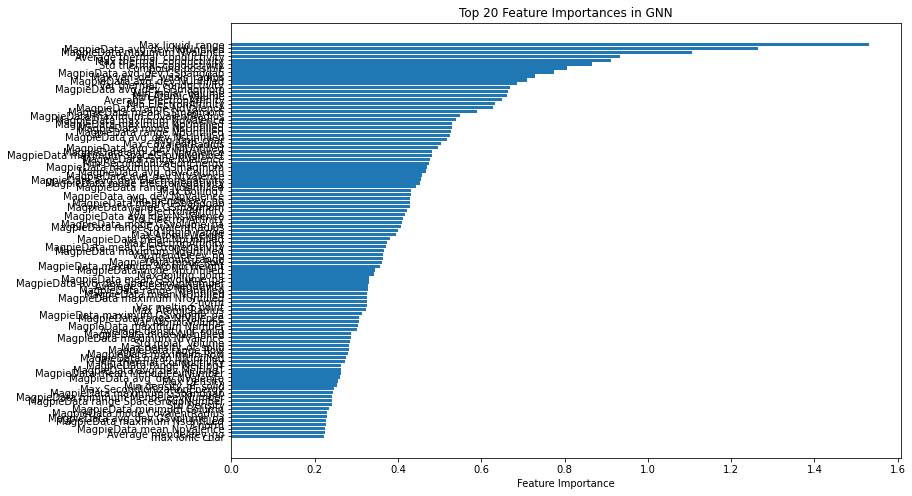

In [12]:
# Function to calculate feature importance
def calculate_feature_importance(model, data, edge_index, device):
    model.eval()
    baseline_pred = model(data, edge_index).cpu().detach().numpy().flatten()
    
    feature_importances = np.zeros(data.shape[1])
    for i in range(data.shape[1]):
        data_perturbed = data.clone().cpu().detach().numpy()
        data_perturbed[:, i] = 0  # Zero out the i-th feature
        data_perturbed = torch.tensor(data_perturbed, dtype=torch.float).to(device)
        
        with torch.no_grad():
            perturbed_pred = model(data_perturbed, edge_index).cpu().detach().numpy().flatten()
        
        feature_importances[i] = np.mean(np.abs(baseline_pred - perturbed_pred))
    
    return feature_importances

# Calculate feature importance for train data
x_train = torch.tensor(norm_train_X, dtype=torch.float).to(device)
feature_importances = calculate_feature_importance(model, x_train, edge_index_train, device)

# Get feature names from the original DataFrame
feature_names = X.columns if hasattr(X, 'columns') else [f'Feature {i}' for i in range(norm_train_X.shape[1])]

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance and select top 20 features
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(100)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances in GNN')
plt.gca().invert_yaxis()
plt.show()